In [1]:
import flopy
import pathlib as pl
import glob
from flopy.utils import GridIntersect, Raster
from shapely.geometry import Polygon

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
import scipy.interpolate
import os
import flopy.utils.binaryfile as bf

In [2]:
flopy.__version__

'3.8.0'

In [3]:
sim = flopy.mf6.MFSimulation.load(
    sim_name='mf6',
    exe_name = 'mf6.exe',
    sim_ws = '.',
    strict=True,
    verbosity_level=1,
    load_only=None,
    verify_data=False,
    write_headers=True,
    lazy_io=False,
    use_pandas=True,
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disu...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package chd...
    loading package riv...
    loading package ghb...
    loading package rch...
    loading package evt...
  loading solution package mf6model...


In [4]:
m=sim.get_model()

In [5]:
m.disu

package_name = disu
filename = mf6_riv_reg.dis
package_type = disu
model_or_simulation_package = model
model_name = mf6model

Block options
--------------------
length_units
{internal}
('feet')


Block dimensions
--------------------
nodes
{internal}
(547154)

nja
{internal}
(2737606)

nvert
{internal}
(2188616)


Block griddata
--------------------
top
{internal}
(array([4970.664888, 4970.446414, 4970.806899, ...,    0.      ,
          0.      ,    0.      ]))

bot
{internal}
(array([-0.5, -0.5, -0.5, ...,  0. ,  0. ,  0. ]))

area
{internal}
(array([10000., 10000., 10000., ...,   100.,   100.,   100.]))

idomain
{internal}
(array([0, 0, 0, ..., 0, 0, 0]))


Block connectiondata
--------------------
iac
{internal}
(array([3, 4, 4, ..., 5, 5, 5]))

ja
{internal}
(array([     0,      1,    235, ...,  21767, 546333, 547152]))

ihc
{internal}
(array([1, 1, 1, ..., 1, 1, 1]))

cl12
{internal}
(array([ 0., 50., 50., ...,  5.,  5.,  5.]))

hwva
{internal}
(array([  0.      , 100.      , 100

In [6]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package mf6model...
  writing model mf6model...
    writing model name file...
    writing package disu...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd-1...
    writing package riv-1...
    writing package ghb-1...
    writing package rch-1...
    writing package evt-1...


In [7]:
success, buff = sim.run_simulation(
    silent=None,
    pause=False,
    report=False,
    processors=None,
    normal_msg='normal termination',
    use_async=False,
    cargs=None,
    custom_print=None,
)

FloPy is using the following executable to run the model: mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:06:57 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held l

In [55]:
hdobj = flopy.utils.HeadFile('mf6_riv_reg.hds', model=m)
hdobj.headers

,kstp,kper,pertim,totim,text,ncol,nrow,ilay
52,1,1,2015.0,2015.0,HEAD,547154,1,1
4377336,1,2,1.0,2016.0,HEAD,547154,1,1
8754620,1,3,1.0,2017.0,HEAD,547154,1,1
13131904,1,4,1.0,2018.0,HEAD,547154,1,1


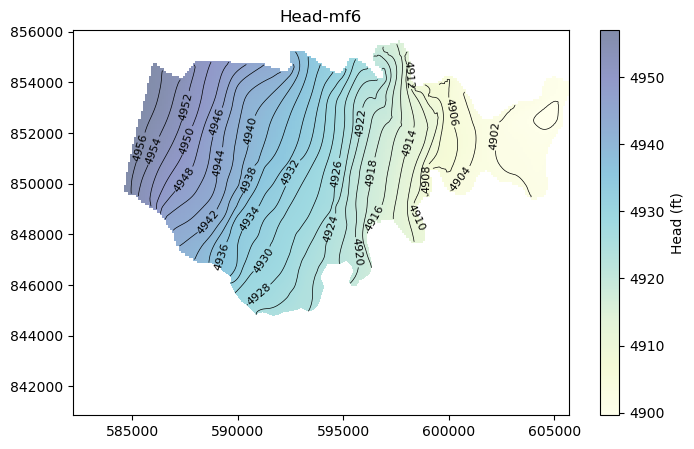

In [137]:
masked_head_array = np.ma.masked_where(head <= 4800, head)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Head-mf6")

mapview = flopy.plot.PlotMapView(model=m, ax=ax)

quadmesh = mapview.plot_array(masked_head_array, alpha=0.5, cmap='YlGnBu')

cbar = plt.colorbar(quadmesh, ax=ax, label='Head (ft)')

contour_set = mapview.contour_array(masked_head_array, levels=levels, colors='black', linewidths=0.5)

labels = pmv.ax.clabel(
    contour_set,
    inline=True,
    fontsize=8,
    inline_spacing=1,
    fmt='%.0f'
)

plt.savefig('heads_mf6.png', dpi=300)
plt.show()

In [29]:
head_values = hdobj.get_data(kstpkper=(0, 0), mflay=0)
head_array = np.array(head_values)
np.savetxt("head_values.txt", head_array, delimiter=",", newline="\n")

In [100]:
mg=m.modelgrid

In [101]:
xoff = mg.xoffset
yoff = mg.yoffset
angrot = mg.angrot
epsg = mg.epsg
proj4 = mg.proj4

print(
    f"xoff: {xoff}\nyoff: {yoff}\nangrot: {angrot}\nepsg: {epsg}\nproj4: {proj4}"
)

xoff: 0.0
yoff: 0.0
angrot: 0.0
epsg: None
proj4: None


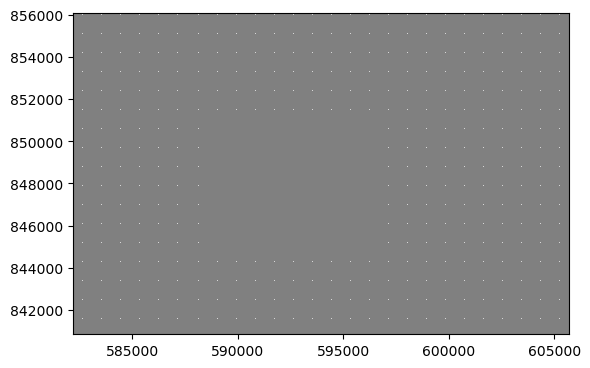

In [102]:
mg.plot()

In [103]:
prj1=('PROJCS["NAD_1927_StatePlane_Wyoming_West_Central_FIPS_4903",'
    'GEOGCS["GCS_North_American_1927",DATUM["D_North_American_1927",'
    'SPHEROID["Clarke_1866",6378206.4,294.9786982]],'
    'PRIMEM["Greenwich",0.0],'
    'UNIT["Degree",0.0174532925199433]],'
    'PROJECTION["Transverse_Mercator"],'
    'PARAMETER["False_Easting",500000.0],'
    'PARAMETER["False_Northing",0.0],'
    'PARAMETER["Central_Meridian",-108.75],'
    'PARAMETER["Scale_Factor",0.9999411764705882],'
    'PARAMETER["Latitude_Of_Origin",40.66666666666666],'
    'UNIT["Foot_US",0.3048006096012192]]'
                            )

In [105]:
mg.set_coord_info(
    xoff=0.,
    yoff=0.,
    angrot=0.,
    crs=prj1,
)

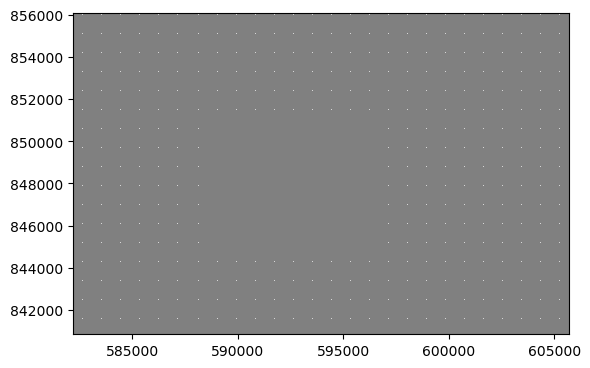

In [106]:
mg.plot()

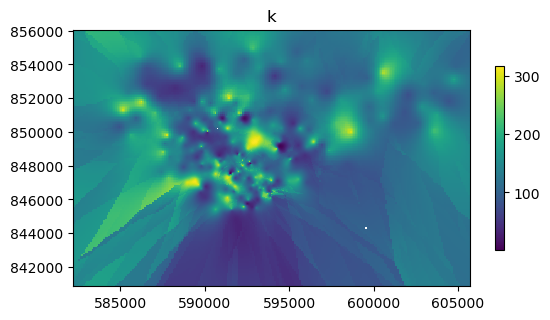

In [132]:
m.npf.k.plot(mflay=0, masked_values=[-9999.0, 0.0, 100.], colorbar=True)
plt.savefig('hk_mf6.png', dpi=500) 

<Axes: title={'center': 'top'}>

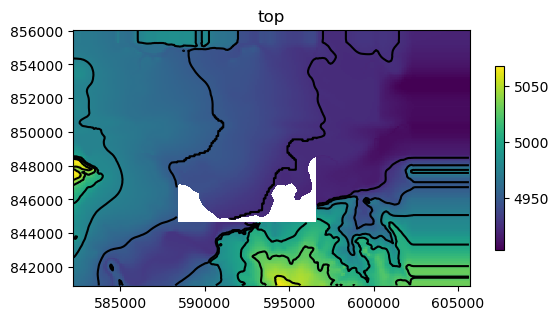

In [133]:
m.dis.top.plot(contour=True, mflay=0, colorbar=True, masked_values=[-9999.0, 0])

<Axes: title={'center': 'bot'}>

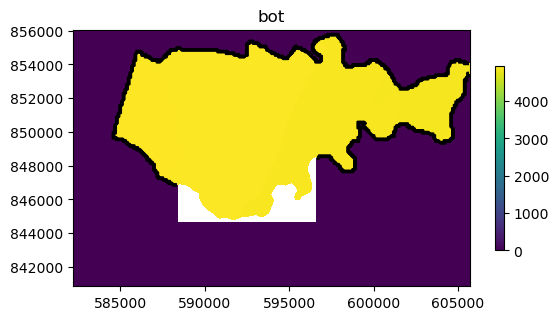

In [120]:
m.dis.bot.plot(contour=True, mflay=0, colorbar=True, masked_values=[-9999.0, 0])